In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from scipy.stats import chi2
from scipy.special import erfinv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import numpy as np

import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../../..')))
from tensiometer import utilities

def estimate_centroid_and_covariance(means, covariances):
    means = np.array(means)
    covariances = np.array(covariances)
    
    # Calculate the inverse of each covariance matrix
    inv_covariances = np.linalg.inv(covariances)
    
    # Calculate the weighted sum of the means
    weighted_means = np.einsum('ijk,ik->ij', inv_covariances, means)
    sum_inv_covariances = np.sum(inv_covariances, axis=0)
    
    # Calculate the centroid
    centroid = np.linalg.solve(sum_inv_covariances, np.sum(weighted_means, axis=0))
    
    # Calculate the covariance of the centroid
    centroid_covariance = np.linalg.inv(sum_inv_covariances)
    
    return centroid, centroid_covariance

2024-12-02 09:52:12.986206: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 09:52:13.051841: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 09:52:13.052730: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 09:52:14.140993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Three moltivariate distributions

In [2]:
#Fixed Parameters
num_parameters = 2
num_datasets = 3

#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = 100*np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')


# Anova-like stimators

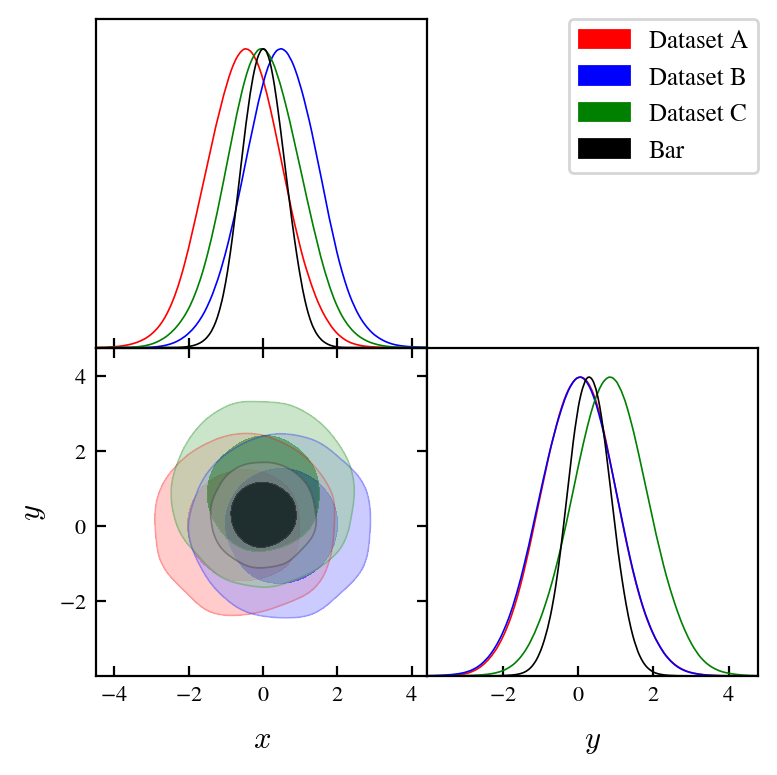

In [3]:
#mean_bar = (mean_A + mean_B + mean_C)/num_datasets

cov_tot = cov_A + cov_B + cov_C
#cov_bar = cov_tot / num_datasets**2

centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_B, mean_C], [cov_A, cov_B, cov_C])
mean_bar = centroid
cov_bar = centroid_covariance


delta_theta_A = mean_A - mean_bar
delta_theta_B = mean_B - mean_bar
delta_theta_C = mean_C - mean_bar

samps_bar = np.random.multivariate_normal(mean_bar, cov_bar, size=10000)
chain_bar = MCSamples(samples=samps_bar, names=names, labels=labels, label='Bar')

colors = ['red', 'blue', 'green', 'black']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_bar],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)
plt.savefig('triangle_plot_2_centroid.pdf')


## $\alpha$-stimator

\begin{equation}
    \alpha = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\sum_{j} C_j}  (\theta_i - \bar{\theta})
\end{equation}

In [4]:
# Utility function to convert confidence level to sigma level
def from_confidence_to_sigma(confidence):
    return np.sqrt(2) * erfinv(confidence)

A_matrix = np.linalg.inv(cov_tot)

alpha = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C))

print(r'alpha: {}'.format(alpha))


# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= alpha)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:4g}'.format(n_sigma))


samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + \
                                                        A_eigenval[1] + B_eigenval[1] + C_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1]
'''

PTE = samp_chi2[samp_chi2 > alpha].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:4g}'.format(n_sigma))



alpha: 0.3333333333333333
[0.44444444 0.44444444 0.44444444 0.44444444 0.44444444 0.44444444]
(1000000, 6)
[[2.05952200e+00 3.00112179e+00 8.71255093e-02 4.79285424e-01
  3.11253852e+00 2.99205073e-01]
 [1.23078905e-01 1.65197185e-02 3.50323538e-03 3.56073211e-01
  9.66186000e-01 8.06893141e-03]
 [2.90841861e-01 2.79563761e+00 4.37231149e-01 1.59350452e-03
  1.31952598e-01 2.77999833e+00]
 ...
 [3.07670254e+00 1.96390639e-01 4.00030732e-01 8.41320693e-01
  4.88252563e-07 1.15693196e-01]
 [2.36856694e+00 7.30056235e-02 3.66847885e-02 7.37928641e-02
  2.90677506e+00 3.27437717e+00]
 [3.11526703e+00 3.23559451e+00 4.51156288e-02 1.98282100e-01
  2.69787633e-01 3.36252543e+00]]
PTE: 0.993327
n_sigma: 0.00836346
PTE: 0.722621
n_sigma: 0.354958


## $\beta$-stimator

\begin{equation}
    \beta = \sum_{i,j} (\theta_i - \theta_j)^{T}  \frac{1}{C_{i}+C_{j}}  (\theta_i - \theta_j)
\end{equation}

In [5]:
beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
     + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
     + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C)))


print(r'beta: {}'.format(beta))

df=num_datasets*num_parameters
PTE = chi2.sf(beta, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > beta].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

beta: 1.5
PTE: 0.9594945602551861
n_sigma: 0.0507879
PTE: 0.95946424
n_sigma: 0.0508259


## $\gamma$-stimator

\begin{equation}
    \gamma = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_{i}}  (\theta_i - \bar{\theta})
\end{equation}

In [6]:
gamma = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A), delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B), delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C), delta_theta_C))

print(r'gamma: {}'.format(gamma))

# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= gamma)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))



samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + \
                                                           A_eigenval[1] + B_eigenval[1] + C_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1]
'''

PTE = samp_chi2[samp_chi2 >= gamma].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

gamma: 1.0
[0.44444444 0.44444444 0.44444444 0.44444444 0.44444444 0.44444444]
(1000000, 6)
[[1.08807083e+00 1.82009495e+00 1.94314302e-03 7.44655413e-02
  7.32512053e-02 1.18285396e+00]
 [4.73649165e-01 3.36513025e+00 2.48779228e+00 4.57019487e-02
  4.73810691e+00 2.10955747e+00]
 [4.96183589e+00 1.13511780e+00 2.28613635e+00 2.02694274e-01
  2.84970337e-01 1.09017702e+00]
 ...
 [5.98709155e-02 5.27151754e-02 1.74102440e+00 3.18545195e-01
  1.92672076e+00 5.44738828e-01]
 [2.69383369e+00 7.20829572e-01 8.53082180e-02 6.63853292e-01
  2.29159180e+00 2.90856839e-01]
 [1.24677579e+00 2.37071907e-01 6.03338275e-01 8.63155764e-01
  4.93001458e-01 2.54542435e+00]]
PTE: 0.895785
n_sigma: 0.130988
PTE: 0.541028
n_sigma: 0.611259


## $\delta$-stimator

\begin{equation}
    \delta = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\bar{C}}  (\theta_i - \bar{\theta}) = n^{2} \cdot \alpha
\end{equation}

In [7]:
A_matrix = np.linalg.inv(cov_bar)

delta = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C))

# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= delta)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))


samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + \
                                                           A_eigenval[1] + B_eigenval[1] + C_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1]
'''



PTE = samp_chi2[samp_chi2 > delta].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))



[4. 4. 4. 4. 4. 4.]
(1000000, 6)
[[1.26002840e+00 1.66211235e+00 1.10468345e+00 2.46554116e+00
  4.73453696e-02 9.36207246e-03]
 [1.60955776e-02 2.71165842e-02 1.03489889e-01 1.20124720e-02
  1.92976434e-04 4.81795170e-02]
 [9.64843216e-02 4.87250031e+00 2.61614271e+00 1.42892793e+00
  1.23246968e-01 2.14928833e-01]
 ...
 [6.07174160e-02 1.48676437e-02 3.27636527e-02 1.66789569e+00
  2.07088282e+00 5.39994236e-02]
 [1.72850725e-01 1.49131537e-01 1.70336055e+00 3.41768838e+00
  8.44829470e-01 1.10071720e+00]
 [2.60981580e-02 1.63749338e-01 1.46275858e-01 3.57018674e+00
  5.35725233e-02 2.76235564e-01]]
PTE: 0.993255
n_sigma: 0.0084537
PTE: 0.723969
n_sigma: 0.353159


## $\epsilon$-stimator

\begin{equation}
    \epsilon = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

In [8]:
epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C))
print(r'epsilon: {}'.format(epsilon))

df=num_datasets*num_parameters
PTE = chi2.sf(epsilon, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > epsilon].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

epsilon: 0.75
PTE: 0.993347785752577
n_sigma: 0.00833741
PTE: 0.9933616
n_sigma: 0.0083201


## $\zeta$-stimator

\begin{equation}
    \zeta = \sum_{i,j} (\theta_i - \theta_j)^{T}  \frac{1}{C_{i}+C_{j}}  (\theta_i - \theta_j) + \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

In [9]:
epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C))

beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
     + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
     + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C)))


zeta = beta + epsilon

print(r'beta: {}'.format(beta))
print(r'epsilon: {}'.format(epsilon))
print(r'zeta: {}'.format(zeta))

df=2*num_datasets*num_parameters
PTE = chi2.sf(zeta, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

beta: 1.5
epsilon: 0.75
zeta: 2.25
PTE: 0.9989154072694686
n_sigma: 0.00135934
